In [1]:
import os
import sys
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
import copy as cp
import scipy.stats
import seaborn

In [2]:
sys.path.insert(1, '../code/')

from rank_functions import compute_transformed_Rmat, compute_mean_ranks
from format_helper_functions import make_aa_dict

In [3]:
def compute_log_prob ( Signmat, Nmat, SignAllmat, NAllmat, nsims=1000 ) :
    

    Npos = (Signmat + Nmat) / 2
    Npos[Nmat == 0] = np.nan

    Nall = (SignAllmat + NAllmat) / 2
    Pall = Nall / NAllmat
    
    kvals = Npos[~np.isnan (Npos)]
    nvals = Nmat[~np.isnan (Npos)]
    probs = Pall[~np.isnan (Npos)]

    logprob = np.sum (np.log10 ( scipy.stats.binom.pmf ( kvals, nvals, probs )))
    
    # compute probability via sampling
    nvals = np.array (nvals, dtype=int)
    probsamples = np.zeros (nsims)
    for i in range (nsims) :
        k_i = np.random.binomial ( nvals, probs )
        probsamples[i] = np.sum (np.log10 ( scipy.stats.binom.pmf ( k_i, nvals, probs )))
            
    return logprob, (np.sum (probsamples < logprob)+1) / (nsims+1)

In [4]:
plt.rcParams.update({'font.size': 8})
plt.rcParams["font.family"] = 'Arial'
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "dejavusans"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Arial"] + plt.rcParams["font.serif"]

In [5]:
# wildtype read counts
input_wt  = np.array ([47550, 62496, 53287])
output_wt = np.array( [162233, 193273, 171470])
y_wt = output_wt / input_wt

In [6]:
# whether to save pdfs
save = True

# input directory
indir = '../results/fosjun/325/fos'
protein = 'fos'
ligand  = 'jun'

# output dir
outdir  = os.path.join (indir, 'plots')
datadir = indir

#ligand  = 'cript'
if not os.path.isdir (outdir) :
    os.makedirs (outdir)

# which focal pair to make supplementary plots for
negative = False
if negative :
    ji = 7
    fi = 7
else :
    fi = 3
    ji = 3

In [7]:
nAA   = 21
alpha = 0.05
mochi_thresholds = np.array ([0.00361875, 0.00238989, 0.00300939])
start_fos = start_jun = 1

In [8]:
# raw data files
ysing = np.loadtxt (os.path.join (datadir, protein + '_Y_singles.txt'))
lsing = np.loadtxt (os.path.join (datadir, ligand + '_Y_singles.txt'))
ydoub = pickle.load ( open (os.path.join (datadir, protein + '_Y_doubles.pkl'), 'rb') )

n0_doub = pickle.load (open (os.path.join (datadir, protein + '_D_neutral.pkl'), 'rb') )
n1_doub = pickle.load (open (os.path.join (datadir, protein + '_D_selection.pkl'), 'rb') )

n0_sing = np.loadtxt (os.path.join (datadir, protein + '_S_neutral.txt'))
n1_sing = np.loadtxt (os.path.join (datadir, protein + '_S_selection.txt'))
n0_cript = np.loadtxt (os.path.join (datadir, ligand + '_S_neutral.txt'))
n1_cript = np.loadtxt (os.path.join (datadir, ligand + '_S_selection.txt'))

# distance matrix
Dist = np.loadtxt ('../data/fosjun/fosjun_distance_matrix.txt')
Df   = Dist[:32,32:]

In [9]:
Llig, L, nreps = ydoub.shape
nlig = int (Llig / nAA)
npos = int (L / nAA)

In [10]:
# make big distance matrix
bigDist = np.zeros ((Llig,L))
for i in range (npos) :
    bigDist[(i*nAA):(i*nAA + nAA),:] = np.reshape (np.repeat (Df[i,:], nAA**2), (nAA, L), order='F')

In [11]:
# change -1s to NAs
if np.nanmin (n0_doub) == -1 :
    n0_doub = np.array (n0_doub, dtype=float)
    n1_doub = np.array (n1_doub, dtype=float)
    n0_doub[n0_doub == -1] = np.nan
    n1_doub[n1_doub == -1] = np.nan
    
    n0_sing = np.array (n0_sing, dtype=float)
    n0_sing[n0_sing == -1] = np.nan
    n0_cript[n0_cript == -1] = np.nan

In [12]:
# p-values
Pvals = np.zeros_like (ydoub)
Ptwo = np.zeros_like (Pvals)
Dmats = np.zeros_like (ydoub)
Lmats = np.zeros ( (L, Llig, nreps))
Dsyms = np.zeros_like (Dmats)
for i in range (nreps) :
    Pvals[:,:,i] = np.loadtxt (os.path.join (indir, 'rep_' + str (i), protein + '_Psymmetric.txt'))
    Dmats[:,:,i] = np.loadtxt (os.path.join (indir, 'rep_' + str (i), protein + '_Dmat.txt'))
    Lmats[:,:,i] = np.loadtxt (os.path.join (indir, 'rep_' + str (i), protein + '_LDmat.txt'))
    Dsyms[:,:,i] = Dmats[:,:,i] + np.transpose (Lmats[:,:,i])
    Ptwo[:,:,i] = 2*np.loadtxt (os.path.join (indir, 'rep_' + str (i), protein + '_Ptwosided.txt'))
    
# fix pseudo-count in two-sided p-value
Ptwo[Ptwo > 1] = 1

In [13]:
# read in mochi p-values
Pmochi = np.zeros_like (Pvals)
Resmochi = np.zeros_like (Pvals)
for i in range (nreps) :
    Pmochi[:,:,i]   = np.loadtxt (os.path.join (indir, 'plots', 'mochi_ps_rep_' + str (i) + '.txt'))
    Resmochi[:,:,i] = np.loadtxt (os.path.join (indir, 'plots', 'mochi_res_rep_' + str (i) + '.txt'))


In [14]:
# compute residuals wrt rbar
y_rank    = np.zeros_like (ysing)
lig_rank  = np.zeros_like (lsing)
rbar_rank = np.zeros_like (ysing)
ligbar_rank = np.zeros_like (lsing)
Rmats     = np.zeros ((Llig, L, nreps))
Rlmats    = np.zeros ((L, Llig, nreps))
for i in range (nreps) :
    Rmats[:,:,i]   = compute_transformed_Rmat (ydoub[:,:,i], M=np.sum (~np.isnan (ysing[:,i])) - 1)
    Rlmats[:,:,i]  = compute_transformed_Rmat (np.transpose (ydoub[:,:,i]), M=np.sum (~np.isnan (lsing[:,i])) - 1)

    y_rank[:,i]    = compute_mean_ranks (ysing[:,i])
    rbar_rank[:,i] = compute_mean_ranks (np.nanmean (Rmats[:,:,i], axis=0))
    lig_rank[:,i]  = compute_mean_ranks (lsing[:,i])
    ligbar_rank[:,i] = compute_mean_ranks (np.nanmean (Rlmats[:,:,i], axis=0))

    
# residuals    
residuals     = rbar_rank - y_rank
lig_residuals = ligbar_rank - lig_rank

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/83694222.py:13: RuntimeWarning: Mean of empty slice
  rbar_rank[:,i] = compute_mean_ranks (np.nanmean (Rmats[:,:,i], axis=0))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/83694222.py:15: RuntimeWarning: Mean of empty slice
  ligbar_rank[:,i] = compute_mean_ranks (np.nanmean (Rlmats[:,:,i], axis=0))


In [15]:
for i in range (nreps) :
    cor_i = scipy.stats.spearmanr (y_rank[:,i], rbar_rank[:,i], nan_policy='omit').statistic
    print (cor_i)
    cor_i = scipy.stats.spearmanr (lig_rank[:,i], ligbar_rank[:,i], nan_policy='omit').statistic
    print (cor_i)

0.9851458755654744
0.9823758267232098
0.9876064645040767
0.9777815960447931
0.9872124137195167
0.9812706564217838


In [16]:
plt.rcParams["figure.figsize"] = (1.25, 1.25)


for pi in range (3) :
    if pi == 0 :
        Pfoc = cp.deepcopy (Ptwo)
    if pi == 1 :
        Pfoc = cp.deepcopy (Pvals)
    if pi == 2 :
        Pfoc = cp.deepcopy (Pmochi)
        Dcp = cp.deepcopy (Resmochi)
            
    if pi in [0,1] :
        p_thres = [alpha]*3
        Dcp = cp.deepcopy (Dsyms)
        
    D_sub = cp.deepcopy (Dcp[ji*nAA:(ji*nAA + nAA), :][:,fi*nAA:(fi*nAA + nAA)])
        

    fig, axs = plt.subplots (3,1, sharex=True, sharey=True)

    bins = np.linspace ( np.nanmin (D_sub), np.nanmax (D_sub), 20)
    for i in range (nreps) :
        hist_i = axs[i].hist ( np.ndarray.flatten (D_sub[:,:,i]), bins=bins,
                               color='gray', edgecolor='black', linewidth=.1)


        axs[i].axvline (0, linestyle='dashed', color='orange', linewidth=1)
    
    axs[1].set_ylabel ('Count')
    axs[-1].set_xlabel ([r'$\hat D_{ij}$',r'$\hat D_{ij}$','Mochi residual'][pi] )
    
    for i in range (nreps) :
        axs[i].yaxis.set_label_position("right")
        axs[i].set_ylabel ('Rep ' + str (i), rotation=270, labelpad=8, fontsize=6)
    
    if save :
        plt.savefig (os.path.join (outdir, str (fi+1) + '_' + str (ji+1) + '_ep_hists_' + ['two', 'one', 'mochi'][pi] + '.pdf'),
                     format='pdf', bbox_inches='tight', transparent=True, dpi=600)
        plt.close ()
    else :
        plt.show ()

In [17]:
# print number of positive tests
D_sub = cp.deepcopy (Dcp[ji*nAA:(ji*nAA + nAA), :][:,fi*nAA:(fi*nAA + nAA)])
P_sub = cp.deepcopy (Pvals[ji*nAA:(ji*nAA + nAA), :][:,fi*nAA:(fi*nAA + nAA)])
print (D_sub.shape)
print (P_sub.shape)

print (alpha)
for i in range (nreps) :
    print (np.sum (P_sub[:,:,i] < alpha))
    print (np.sum (np.logical_and (D_sub[:,:,i] > 0, P_sub[:,:,i] < alpha)))

(21, 21, 3)
(21, 21, 3)
0.05
34
34
38
38
27
27


In [18]:
 # now compute power and false positives
ys = cp.deepcopy (ysing[:,0])
ls = cp.deepcopy (lsing[:,0])
ybinsize = 50
lbinsize = 50
    
nys   = np.sum (~np.isnan (ys))
ybins = np.linspace (0, nys, int (nys / ybinsize))
nls = np.sum (~np.isnan (ls))
lbins = np.linspace (0, nls, int (nls / lbinsize))

In [19]:
# spectral color map
spec = mpl.colormaps['Spectral']
norm = plt.Normalize(-1,1)

for pi in range (3) :
    if pi == 0 :
        Pfoc = cp.deepcopy (Ptwo)
        p_thres = [alpha]*3
    if pi == 1 :
        Pfoc = cp.deepcopy (Pvals)
        p_thres = [alpha]*3
    if pi == 2 :
        Pfoc = cp.deepcopy (Pmochi)
        p_thres = mochi_thresholds

    Power = np.zeros ( (len (lbins) - 1, len (ybins) - 1, nreps) )
    Nsig  = np.zeros_like (Power)
    Sign  = np.zeros_like (Power)
    Npos  = np.zeros_like (Power)

    for k in range (nreps) :
        for i in range (nAA) :
            bi = np.argmin (y_rank[fi*nAA + i,k] - ybins > 0) -1
            for j in range (nAA) :
                li = np.argmin (lig_rank[ji*nAA + j,k] - lbins > 0) -1

                if ~np.isnan (Pfoc[ji*nAA + j,fi*nAA + i,k]) :
                    Power[bi,li,k] += 1
                if Pfoc[ji*nAA + j,fi*nAA + i,k] <= p_thres[k] :
                    Sign[bi,li,k] += (2*(Dsyms[ji*nAA + j,fi*nAA + i, k] > 0) - 1)
                    Nsig[bi,li,k] += 1
                    Npos[bi,li,k] += (Dsyms[ji*nAA + j,fi*nAA + i, k] > 0) 

    SignAll = np.zeros_like (Power)
    SigAll  = np.zeros_like (Power)
    for k in range (nreps) :
        for i in range (L) :
            if ~np.isnan (y_rank[i,k]) :
                bi = np.argmin (y_rank[i,k]+1 - ybins > 0)-1
            for j in range (L) :
                if ~np.isnan (lig_rank[j,k]) :
                    li = np.argmin (lig_rank[j,k]+1 - lbins > 0)-1

                    if np.logical_and (~np.isnan (Pfoc[j,i,k]), Pfoc[j,i,k] <= p_thres[k]) :
                        SignAll[bi,li,k] += (2*(Dsyms[j,i,k] > 0) - 1)
                        SigAll[bi,li,k]  += 1
                        
    
    # test for significance
    logprob = np.zeros (nreps)
    pprobs  = np.zeros (nreps)
    for r in range (nreps) :
        logprob[r], pprobs[r] = compute_log_prob (Sign[:,:,r], Nsig[:,:,r], SignAll[:,:,r], SigAll[:,:,r])
    print (pprobs)
    print (logprob)
    
    plt.rcParams["figure.figsize"] = (4, 3)

    fig, axs = plt.subplots (1, 4, sharex=True, sharey=True)

    myp = axs[0].imshow (np.nanmean (Power, axis=2), cmap='gray_r')
    axs[0].set_ylabel ('Fos bin', labelpad=0)
    cbar = fig.colorbar (myp, ax=axs[0], location='top', shrink=0.75, aspect=10 )
    cbar.set_label ('# observ.', size=6, labelpad=2)
    cbar.ax.tick_params (labelsize=6, length=3, pad=-.5)

    myp = axs[1].imshow (np.nanmean (Nsig, axis=2), cmap='rocket_r')
    cbar = fig.colorbar (myp, ax=axs[1], location='top', shrink=0.75, aspect=10)
    cbar.set_label (r'# signif.', size=6, labelpad=2)
    cbar.ax.tick_params (labelsize=6, length=3, pad=-.5)

    myp = axs[2].imshow (np.nanmean (Sign / Nsig, axis=2), cmap='Spectral', vmin=-1, vmax=1)
    cbar = fig.colorbar (myp, ax=axs[2], location='top', shrink=0.75, aspect=10)
    cbar.set_label ( r'avg. sign $\hat D_{ij}$', size=6, labelpad=2)
    cbar.ax.tick_params (labelsize=6, length=3, pad=-.5)

    myp = axs[3].imshow (np.nanmean (SignAll / SigAll, axis=2), cmap='Spectral', vmin=-1, vmax=1)
    axs[3].set_xlabel ('Jun bin', labelpad=0)
    cbar = fig.colorbar (myp, ax=axs[3], location='top', shrink=0.75, aspect=10)
    cbar.set_label ( r'avg. sign $\hat D_{ij}$', size=6, labelpad=2)
    cbar.ax.tick_params (labelsize=6, length=3, pad=-.5)
    
    Cow = np.nanmean (Sign / Nsig, axis=2)
    x, y = np.where (~np.isnan (Cow))
    for i in range (len (x)) : 
        axs[3].scatter (y[i], x[i], color=spec( norm (Cow[x[i], y[i]])),
                        edgecolor='black', linewidth=.05,
                        s=np.nanmean (Nsig, axis=2)[x[i], y[i]])
        
    for i in range (4) :
        axs[i].set_xticks (np.arange (0, len (lbins), 5),
                           np.array (np.arange (0, len (lbins), 5), dtype=int),
                           fontsize=6)
        axs[i].set_yticks (np.arange (0, len (lbins), 5),
                           np.array (np.arange (0, len (lbins), 5), dtype=int),
                           fontsize=6)
        axs[i].tick_params (length=2)
        axs[i].yaxis.set_tick_params (pad=1)
        axs[i].set_xlabel ('Jun bin', labelpad=0)

    if save :
        plt.savefig (os.path.join (outdir, str (fi+1) + '_' + str (ji+1) + '_negative_ep_' + ['two', 'one', 'mochi'][pi] + '.pdf'),
                     format='pdf', bbox_inches='tight', transparent=True, dpi=600)
        plt.close ()
    else :
        plt.show ()

[0.000999 0.000999 0.000999]
[ -9.73984379 -10.10199024  -7.4409343 ]


/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1176525793.py:72: RuntimeWarning: invalid value encountered in divide
  myp = axs[2].imshow (np.nanmean (Sign / Nsig, axis=2), cmap='Spectral', vmin=-1, vmax=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1176525793.py:72: RuntimeWarning: Mean of empty slice
  myp = axs[2].imshow (np.nanmean (Sign / Nsig, axis=2), cmap='Spectral', vmin=-1, vmax=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1176525793.py:83: RuntimeWarning: invalid value encountered in divide
  Cow = np.nanmean (Sign / Nsig, axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1176525793.py:83: RuntimeWarning: Mean of empty slice
  Cow = np.nanmean (Sign / Nsig, axis=2)


[0.18381618 0.41558442 0.25174825]
[-2.03904284 -1.77540844 -1.63816092]


/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1176525793.py:72: RuntimeWarning: invalid value encountered in divide
  myp = axs[2].imshow (np.nanmean (Sign / Nsig, axis=2), cmap='Spectral', vmin=-1, vmax=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1176525793.py:72: RuntimeWarning: Mean of empty slice
  myp = axs[2].imshow (np.nanmean (Sign / Nsig, axis=2), cmap='Spectral', vmin=-1, vmax=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1176525793.py:83: RuntimeWarning: invalid value encountered in divide
  Cow = np.nanmean (Sign / Nsig, axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1176525793.py:83: RuntimeWarning: Mean of empty slice
  Cow = np.nanmean (Sign / Nsig, axis=2)


[0.98401598 0.86213786 0.98901099]
[-2.57358492 -2.76477769 -1.88490227]


/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1176525793.py:72: RuntimeWarning: invalid value encountered in divide
  myp = axs[2].imshow (np.nanmean (Sign / Nsig, axis=2), cmap='Spectral', vmin=-1, vmax=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1176525793.py:72: RuntimeWarning: Mean of empty slice
  myp = axs[2].imshow (np.nanmean (Sign / Nsig, axis=2), cmap='Spectral', vmin=-1, vmax=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1176525793.py:83: RuntimeWarning: invalid value encountered in divide
  Cow = np.nanmean (Sign / Nsig, axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1176525793.py:83: RuntimeWarning: Mean of empty slice
  Cow = np.nanmean (Sign / Nsig, axis=2)


In [20]:
# sign matrix
Dsign = cp.deepcopy (Dsyms)
Dsign[Dsyms > 0] = 1
Dsign[Dsyms < 0] = -1
print (Dsign.shape)

plt.rcParams["figure.figsize"] = (1, 1)

fig, axs = plt.subplots ()

maxval = np.nanmax (y_rank)
hm     = axs.scatter (compute_mean_ranks (np.nanmean (y_rank, axis=1)),
                      np.nanmean (rbar_rank, axis=1),
                      c=np.nanmean (np.nanmean (Dsign, axis=2), axis=0),
                      cmap='Spectral', vmin=-1, vmax=1, s=5,
                      edgecolor='black', linewidth=0.05)

axs.set_xticks ( np.arange (0, maxval, 200),
                   np.array (np.arange (0, maxval, 200), dtype=int),
                   fontsize=6)
axs.set_yticks ( np.arange (0, maxval, 200),
                    np.array (np.arange (0, maxval, 200), dtype=int),
                    fontsize=6)

axs.plot (np.linspace (0, maxval, 400), np.linspace (0, maxval, 400),
             color='black', linestyle='dashed', linewidth=.5)
axs.set_xlabel (r'$\bar R_i^{fos}$', labelpad=0, fontsize=7)
axs.tick_params (length=2, pad=1)
axs.yaxis.set_tick_params (pad=2)

axs.set_ylabel (r'Rank of $\bar R_{\cdot,i}$', labelpad=0, fontsize=7)

if save :
    plt.savefig (os.path.join (outdir, 'fos_rank.svg'),
                 format='svg', bbox_inches='tight', dpi=600, transparent=True)
    plt.close ()
else :
    plt.show ()

(672, 672, 3)


/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1784802396.py:12: RuntimeWarning: Mean of empty slice
  hm     = axs.scatter (compute_mean_ranks (np.nanmean (y_rank, axis=1)),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1784802396.py:13: RuntimeWarning: Mean of empty slice
  np.nanmean (rbar_rank, axis=1),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1784802396.py:14: RuntimeWarning: Mean of empty slice
  c=np.nanmean (np.nanmean (Dsign, axis=2), axis=0),


In [21]:
plt.rcParams["figure.figsize"] = (3, 1.25)

fig, axs = plt.subplots (1,2, sharex=True, sharey=True, constrained_layout=True)

maxval = np.nanmax ( [np.nanmax (y_rank), np.nanmax (lig_rank)])
hm = axs[0].scatter (compute_mean_ranks (np.nanmean (y_rank, axis=1)),
                     np.nanmean (rbar_rank, axis=1),
                     c=np.nanmean (np.nanmean (Dsign, axis=2), axis=0),
                     cmap='Spectral', vmin=-1, vmax=1, s=5,
                     edgecolor='black', linewidth=0.01) #vmin=minread, vmax=maxread)
axs[1].scatter (compute_mean_ranks (np.nanmean (lig_rank, axis=1)),
                np.nanmean (ligbar_rank, axis=1),
                c=np.nanmean (np.nanmean (Dsign, axis=2), axis=1),
                     cmap='Spectral', vmin=-1, vmax=1, s=5,
                     edgecolor='black', linewidth=0.01) 
cbar = fig.colorbar (hm, ax=axs[1], )
cbar.ax.tick_params (labelsize=6)
cbar.set_label (label=r'$\bar{sign}(\bar D_{ij})$', size=6)

for i in range (2) :
    axs[i].set_xticks ( np.arange (0, maxval, 250),
                       np.array (np.arange (0, maxval, 250), dtype=int),
                       fontsize=6)
    axs[i].set_yticks ( np.arange (0, maxval, 250),
                        np.array (np.arange (0, maxval, 250), dtype=int),
                        fontsize=6)

    axs[i].plot (np.linspace (0, maxval, 400), np.linspace (0, maxval, 400),
                 color='black', linestyle='dashed', linewidth=.5)
    axs[i].annotate ('block ' + str (i+1), (25,720))
    axs[i].set_xlabel ([r'$\bar R_i^{fos}$', r'$\bar R_i^{jun}$'][i], labelpad=0, fontsize=6)
    axs[i].tick_params (length=2)
    axs[i].yaxis.set_tick_params (pad=2)

axs[0].set_ylabel (r'$R[\bar R_{\cdot,i}]$', labelpad=0, fontsize=6)

if save :
    plt.savefig (os.path.join (outdir, 'single_cor.pdf'), bbox_inches='tight', dpi=600)
    plt.close ()
else :
    plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1867269930.py:6: RuntimeWarning: Mean of empty slice
  hm = axs[0].scatter (compute_mean_ranks (np.nanmean (y_rank, axis=1)),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1867269930.py:7: RuntimeWarning: Mean of empty slice
  np.nanmean (rbar_rank, axis=1),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1867269930.py:8: RuntimeWarning: Mean of empty slice
  c=np.nanmean (np.nanmean (Dsign, axis=2), axis=0),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1867269930.py:11: RuntimeWarning: Mean of empty slice
  axs[1].scatter (compute_mean_ranks (np.nanmean (lig_rank, axis=1)),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1867269930.py:12: RuntimeWarning: Mean of empty slice
  np.nanmean (ligbar_rank, axis=1),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/1867269930.py:13: RuntimeWarning: Mean of empty slice
  c=np.nanmean (np.nanmean (D

In [22]:
rhos = np.zeros (nreps)
for i in range (nreps) :
    print (scipy.stats.spearmanr (rbar_rank[:,i], ysing[:,i], nan_policy='omit'))
    rhos[i] = scipy.stats.spearmanr (rbar_rank[:,i], ysing[:,i], nan_policy='omit').statistic

print (np.mean (rhos))

SignificanceResult(statistic=0.9851458755654744, pvalue=0.0)
SignificanceResult(statistic=0.9876064645040767, pvalue=0.0)
SignificanceResult(statistic=0.9872124137195167, pvalue=0.0)
0.9866549179296893


In [23]:
plt.rcParams["figure.figsize"] = (4, 1.75)

fig, axs = plt.subplots (1, 2, sharex=True, sharey=True, constrained_layout=True)

myp = axs[0].hexbin (np.ndarray.flatten (n0_sing),
               np.ndarray.flatten (residuals), xscale='log', cmap='gray_r', gridsize=20)

for i in range (nreps) :
    axs[0].scatter (n0_sing[7*nAA:(7*nAA + nAA),i], residuals[7*nAA:(7*nAA + nAA),i],
                    color='darkorange', s=2, linewidth=0.05,
                    label='T8 FOS', alpha=.75)
    print (np.nanmean (n0_sing[7*nAA:(7*nAA + nAA),i]))
    print (np.nanmean (n0_sing[:,i]))
fig.colorbar (myp, ax=axs[0], shrink=.75, label='Count')
axs[0].set_ylabel ('Residuals')
axs[0].annotate ('T8 Fos', (20, 200), color='darkorange')

myp = axs[1].hexbin (np.ndarray.flatten (n0_cript),
                     np.ndarray.flatten (lig_residuals), xscale='log', cmap='gray_r', gridsize=20)
for i in range (nreps) :
    axs[1].scatter (n0_cript[7*nAA:(7*nAA + nAA),i], lig_residuals[7*nAA:(7*nAA + nAA),i],
                    color='dodgerblue', s=2, linewidth=0.05,
                    label='T8 FOS', alpha=.75)
    print (np.nanmean (n0_cript[7*nAA:(7*nAA + nAA),i]))
    print (np.nanmean (n0_cript[:,i]))
fig.colorbar (myp, ax=axs[1], shrink=.75, label='Count')
axs[1].annotate ('V8 Jun', (20, 200), color='dodgerblue')

axs[0].set_yticks (np.arange (-100,250,100),np.arange (-100,250,100))


for i in range (2) :
    axs[i].set_xlabel (r'$\hat N_{i}^0$', labelpad=0)
    axs[i].tick_params (length=2)

if save :
    plt.savefig (os.path.join (outdir, 'single_residual_depth.pdf'),
                 bbox_inches='tight', dpi=600, transparent=True)
    plt.close ()
else :
    plt.show ()

1005.7
945.35625
1310.1
1231.5984375
1103.55
1044.0297339593114
873.7
857.290625
1144.3
1123.696875
967.05
951.9890625


In [24]:
plt.rcParams["figure.figsize"] = (5.5, 2.75)

fig, axs = plt.subplots (1, 2, sharex=True, sharey=True, constrained_layout=True)

minval = np.nanmin ([np.nanmin (ysing), np.nanmin (lsing)])
maxval = np.nanmax ([np.nanmax (ysing), np.nanmax (lsing)])


hm = axs[0].scatter (n0_sing, residuals, c=ysing,
             cmap='gray', norm=mpl.colors.LogNorm (vmin=minval, vmax=maxval), 
             edgecolor='black', linewidth=0.01, s=10)
axs[1].scatter (n0_cript, lig_residuals, c=lsing,
             cmap='gray', norm=mpl.colors.LogNorm (vmin=minval, vmax=maxval),
             edgecolor='black', linewidth=0.01, s=10)
fig.colorbar (hm, ax=axs[1], label=r'$\hat Y_{i}$')

for i in range (2) :
    axs[i].set_xscale ('log')
    axs[i].set_xlabel (r'$\hat N_i^0$')
    
axs[0].set_title ('FOS')
axs[1].set_title ('JUN')

axs[0].set_ylabel ('Residual')

if save :
    plt.savefig (os.path.join (outdir, 'single_residual_depth_2.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/4136116595.py:4: RuntimeWarning: Mean of empty slice
  Ymat = np.reshape (np.repeat (np.nanmean (ysing, axis=1), L), (L,L))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/4136116595.py:5: RuntimeWarning: Mean of empty slice
  Ylmat = np.reshape (np.repeat (np.nanmean (lsing, axis=1), L), (L,L))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/4136116595.py:8: RuntimeWarning: Mean of empty slice
  plt.scatter (Yij, np.nanmean (ydoub, axis=2), s=.5, c=np.nanmean (n0_doub, axis=2),


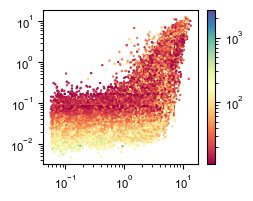

In [25]:
plt.rcParams["figure.figsize"] = (2.5,2)

# pretend additive
Ymat = np.reshape (np.repeat (np.nanmean (ysing, axis=1), L), (L,L))
Ylmat = np.reshape (np.repeat (np.nanmean (lsing, axis=1), L), (L,L))
Yij  = Ylmat + np.transpose (Ymat)

plt.scatter (Yij, np.nanmean (ydoub, axis=2), s=.5, c=np.nanmean (n0_doub, axis=2),
             cmap='Spectral', norm=mpl.colors.LogNorm ())

plt.colorbar ()
plt.xscale ('log')
plt.yscale ('log')
plt.show ()

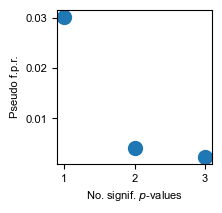

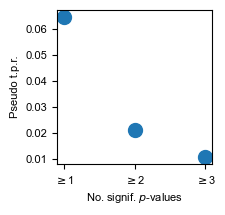

In [26]:
# find false positive rate as a function of number of reps signif
nSignif = np.sum (Pvals <= alpha, axis=2)
fp_rep  = np.zeros (nreps)
tp_rep  = np.zeros (nreps)
for i in range (1,nreps+1) :
    fp_rep[i-1] = np.sum (np.logical_and (nSignif == i, np.transpose (bigDist) > 5)) / np.sum (bigDist > 5)
    tp_rep[i-1] = np.sum (np.logical_and (nSignif >= i, np.transpose (bigDist) <= 5)) / np.sum (bigDist <= 5)

plt.rcParams["figure.figsize"] = (2,2)
    
plt.scatter (np.arange (1,nreps+1,1), fp_rep, s=100)
plt.xlabel ('No. signif. $p$-values')
plt.ylabel ('Pseudo f.p.r.')
plt.show ()

plt.scatter (np.arange (1,nreps+1,1), tp_rep, s=100)
plt.xticks (np.arange (1,nreps+1,1), [r'$\geq$' + str (i) for i in range (1,nreps+1)])
plt.xlabel (r'No. signif. $p$-values')
plt.ylabel ('Pseudo t.p.r.')
plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4126/4232974841.py:3: RuntimeWarning: Mean of empty slice
  plt.scatter (np.nanmean (lig_rank, axis=1), np.sum (np.nanmean (n1_doub == 0, axis=2), axis=1), s=20)


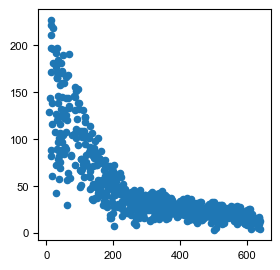

In [27]:
plt.rcParams["figure.figsize"] = (3, 3)

plt.scatter (np.nanmean (lig_rank, axis=1), np.sum (np.nanmean (n1_doub == 0, axis=2), axis=1), s=20)
plt.show ()

In [28]:
for r in range (nreps) :
    print (np.sum (~np.isnan (n0_doub[:,:,r])))
    print (np.sum (~np.isnan (n0_doub[:,:,r])) / (nlig * npos * (nAA - 1)**2))
    print (np.sum (~np.isnan (n0_sing[:,r])) / (npos*(nAA-1)))
    print (np.sum (~np.isnan (n0_cript[:,r])) / (nlig*(nAA-1)))
    print ()

168242
0.4107470703125
1.0
1.0

183523
0.44805419921875
1.0
1.0

172865
0.42203369140625
0.9984375
1.0



In [29]:
mochi_thresholds

array([0.00361875, 0.00238989, 0.00300939])